<a href="https://colab.research.google.com/github/duwi27sulis/Peramalan-LSTM_75-25/blob/main/Revnb_75_25_Update_H1_T12_Fix_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.6 MB/s eta 0:00:00


In [2]:
# Package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [3]:
# Fix random seed for reproducibility
tf.random.set_seed(10)
plt.rcParams['figure.figsize'] = (12,6)

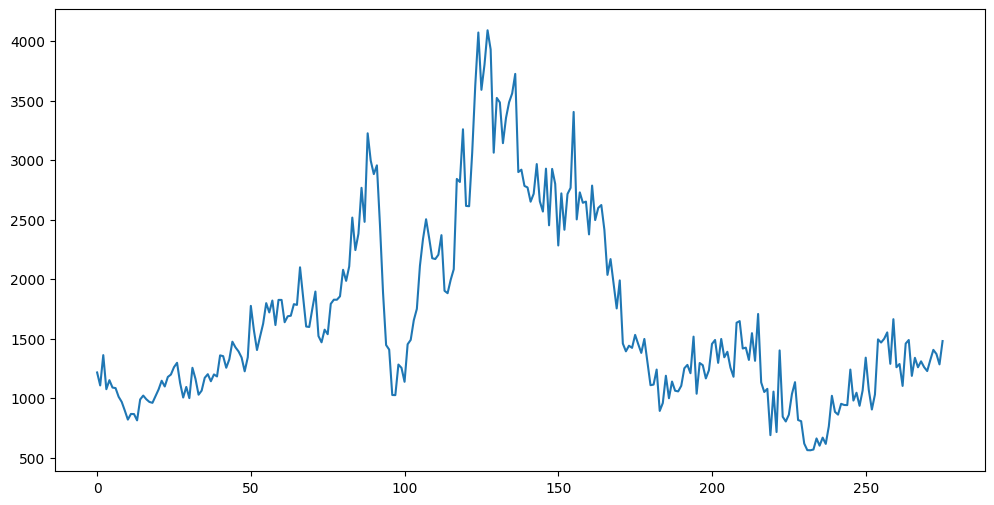

In [4]:
# Input Data
url = "https://raw.githubusercontent.com/duwi27sulis/Analisis_Data_LSTM/main/Ekspor-Migas-2001-2023.csv"
df = pd.read_csv(url, sep=",")
df['Tanggal'] = pd.to_datetime(df.Tanggal)
dataframe = pd.read_csv(url, usecols=[1], engine='python')
dataset = dataframe.values.astype('float32')
plt.plot(dataset)

In [5]:
# Pembagian data
#train_size = int(len(dataset)*0.75)
train_size = 207
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [6]:
time_steps = 12
last_row_train = train[-time_steps:]
test = np.concatenate([last_row_train, test], axis=0)

In [7]:
ytest = test
ytrain = train

In [8]:
# Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit(dataset)

train = scaled_data.transform(train)
test = scaled_data.transform(test)

In [9]:
# Fungsi untuk membuat dataset
def create_dataset (X, y, time_steps = time_steps):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
X_test, y_test = create_dataset(test, test)
X_train, y_train = create_dataset(train, train)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (195, 12, 1)
y_train.shape:  (195, 1)
X_test.shape:  (69, 12, 1)
y_test.shape:  (69, 1)


In [11]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [12]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20)

In [13]:
def objective(trial):
    # Define the search space
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Cross-validation scores
    cv_scores = []

    for fold_index, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build the model
        model = Sequential([
            LSTM(units=lstm_units, input_shape=(X_train_fold.shape[1], 1)),
            Dropout(dropout_rate),
            Dense(1)
        ])

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            optimizer = SGD(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, val_pred)
        cv_scores.append(mse)

        # Print MSE for each fold
        print(f"Fold {fold_index + 1}: MSE = {mse:.4f}")

    # Print average MSE across all folds
    print(f"Average MSE: {np.mean(cv_scores):.4f}")

    return np.mean(cv_scores)

In [14]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)

[I 2024-08-14 01:34:44,003] A new study created in memory with name: no-name-6019003d-5026-40ac-bc0c-1e4716176ff7


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 1: MSE = 0.1128
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 2: MSE = 1.2387
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Fold 3: MSE = 0.0379
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 4: MSE = 0.8061


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-08-14 01:35:05,629] Trial 0 finished with value: 0.43994373083114624 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.43994373083114624.


Fold 5: MSE = 0.0043
Average MSE: 0.4399


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 1: MSE = 0.0057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 2: MSE = 0.0323
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 3: MSE = 0.1266
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 4: MSE = 0.0221
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-08-14 01:35:29,019] Trial 1 finished with value: 0.03927076607942581 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.03927076607942581.


Fold 5: MSE = 0.0096
Average MSE: 0.0393
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Fold 1: MSE = 0.0071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Fold 2: MSE = 0.0339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 3: MSE = 0.0282
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Fold 4: MSE = 0.0201
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2024-08-14 01:35:51,242] Trial 2 finished with value: 0.019357388839125633 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.019357388839125633.


Fold 5: MSE = 0.0075
Average MSE: 0.0194
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Fold 1: MSE = 0.0360
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 2: MSE = 0.0519
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Fold 3: MSE = 0.0419
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Fold 4: MSE = 0.0257
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


[I 2024-08-14 01:36:09,799] Trial 3 finished with value: 0.03170588240027428 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.019357388839125633.


Fold 5: MSE = 0.0030
Average MSE: 0.0317
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 1: MSE = 0.0848
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 2: MSE = 0.1929
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Fold 3: MSE = 0.5495
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Fold 4: MSE = 0.1820
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-08-14 01:36:30,974] Trial 4 finished with value: 0.20504269003868103 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.019357388839125633.


Fold 5: MSE = 0.0160
Average MSE: 0.2050
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 1: MSE = 0.0102
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 2: MSE = 0.0285
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Fold 3: MSE = 0.0305
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Fold 4: MSE = 0.0398
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-08-14 01:36:50,945] Trial 5 finished with value: 0.024363478645682335 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.019357388839125633.


Fold 5: MSE = 0.0129
Average MSE: 0.0244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Fold 1: MSE = 1.1992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Fold 2: MSE = 0.1769
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Fold 3: MSE = 0.1234
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 4: MSE = 0.0198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


[I 2024-08-14 01:37:22,081] Trial 6 finished with value: 0.3042222261428833 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.019357388839125633.


Fold 5: MSE = 0.0018
Average MSE: 0.3042
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Fold 1: MSE = 0.0156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 2: MSE = 0.0455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 3: MSE = 0.0967
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 4: MSE = 0.0258
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


[I 2024-08-14 01:37:38,097] Trial 7 finished with value: 0.03838188201189041 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.019357388839125633.


Fold 5: MSE = 0.0082
Average MSE: 0.0384
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 1: MSE = 0.0118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Fold 2: MSE = 0.0172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 3: MSE = 0.0615
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Fold 4: MSE = 0.0235
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


[I 2024-08-14 01:38:05,065] Trial 8 finished with value: 0.023292751982808113 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.019357388839125633.


Fold 5: MSE = 0.0024
Average MSE: 0.0233
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Fold 1: MSE = 0.0134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Fold 2: MSE = 0.0675
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Fold 3: MSE = 0.1204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 4: MSE = 0.0596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2024-08-14 01:38:30,708] Trial 9 finished with value: 0.05885671451687813 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.019357388839125633.


Fold 5: MSE = 0.0334
Average MSE: 0.0589
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 1: MSE = 0.0057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Fold 2: MSE = 0.0319
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Fold 3: MSE = 0.0407
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Fold 4: MSE = 0.0138
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


[I 2024-08-14 01:38:56,506] Trial 10 finished with value: 0.019727829843759537 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.019357388839125633.


Fold 5: MSE = 0.0065
Average MSE: 0.0197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Fold 1: MSE = 0.0068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 2: MSE = 0.0366
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Fold 3: MSE = 0.0441
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Fold 4: MSE = 0.0121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


[I 2024-08-14 01:39:18,887] Trial 11 finished with value: 0.021129269152879715 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.019357388839125633.


Fold 5: MSE = 0.0060
Average MSE: 0.0211
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Fold 1: MSE = 0.0029
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Fold 2: MSE = 0.0406
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 3: MSE = 0.0557
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 4: MSE = 0.0125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2024-08-14 01:39:51,981] Trial 12 finished with value: 0.023614292964339256 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.019357388839125633.


Fold 5: MSE = 0.0064
Average MSE: 0.0236
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 1: MSE = 0.0049
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
Fold 2: MSE = 0.0357
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Fold 3: MSE = 0.0584
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Fold 4: MSE = 0.0117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-08-14 01:40:17,704] Trial 13 finished with value: 0.023130448535084724 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.019357388839125633.


Fold 5: MSE = 0.0051
Average MSE: 0.0231
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 1: MSE = 0.0046
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Fold 2: MSE = 0.0358
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Fold 3: MSE = 0.0266
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 4: MSE = 0.0098
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


[I 2024-08-14 01:40:40,642] Trial 14 finished with value: 0.016120178624987602 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0038
Average MSE: 0.0161
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 1: MSE = 0.0140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 2: MSE = 0.0396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 3: MSE = 0.0196
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 4: MSE = 0.0134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


[I 2024-08-14 01:41:04,066] Trial 15 finished with value: 0.017873648554086685 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0028
Average MSE: 0.0179
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Fold 1: MSE = 0.0150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 2: MSE = 0.0370
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Fold 3: MSE = 0.0200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Fold 4: MSE = 0.0101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


[I 2024-08-14 01:41:29,194] Trial 16 finished with value: 0.016995739191770554 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0029
Average MSE: 0.0170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 1: MSE = 0.0179
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Fold 2: MSE = 0.0227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Fold 3: MSE = 0.0284
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Fold 4: MSE = 0.0152
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-08-14 01:41:52,570] Trial 17 finished with value: 0.017891421914100647 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0052
Average MSE: 0.0179
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Fold 1: MSE = 0.0208
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Fold 2: MSE = 0.0430
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Fold 3: MSE = 0.0230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Fold 4: MSE = 0.0125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


[I 2024-08-14 01:42:14,251] Trial 18 finished with value: 0.02065463177859783 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0039
Average MSE: 0.0207
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Fold 1: MSE = 0.0110
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 2: MSE = 0.0316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Fold 3: MSE = 0.0222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Fold 4: MSE = 0.0135
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


[I 2024-08-14 01:42:37,816] Trial 19 finished with value: 0.01615883782505989 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0026
Average MSE: 0.0162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
Fold 1: MSE = 0.0203
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 2: MSE = 0.0494
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 3: MSE = 0.0187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Fold 4: MSE = 0.0186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


[I 2024-08-14 01:43:04,086] Trial 20 finished with value: 0.02173585444688797 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0016
Average MSE: 0.0217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Fold 1: MSE = 0.0120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 2: MSE = 0.0372
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 3: MSE = 0.0229
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Fold 4: MSE = 0.0140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2024-08-14 01:43:29,412] Trial 21 finished with value: 0.01784774847328663 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0031
Average MSE: 0.0178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 1: MSE = 0.0114
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Fold 2: MSE = 0.0377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 3: MSE = 0.0277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 4: MSE = 0.0099
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


[I 2024-08-14 01:43:51,024] Trial 22 finished with value: 0.017744582146406174 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0020
Average MSE: 0.0177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 1: MSE = 0.0226
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 2: MSE = 0.0428
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 3: MSE = 0.0304
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Fold 4: MSE = 0.0117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2024-08-14 01:44:12,587] Trial 23 finished with value: 0.021905643865466118 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0020
Average MSE: 0.0219
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Fold 1: MSE = 0.0217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 2: MSE = 0.0298
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Fold 3: MSE = 0.0293
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 4: MSE = 0.0139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-08-14 01:44:34,671] Trial 24 finished with value: 0.019862253218889236 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0046
Average MSE: 0.0199
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 1: MSE = 0.1550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
Fold 2: MSE = 0.0567
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Fold 3: MSE = 0.4029
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Fold 4: MSE = 0.1197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


[I 2024-08-14 01:44:56,878] Trial 25 finished with value: 0.1473839432001114 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0027
Average MSE: 0.1474
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 1: MSE = 0.0116
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 2: MSE = 0.0352
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 3: MSE = 0.0239
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Fold 4: MSE = 0.0126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


[I 2024-08-14 01:45:19,480] Trial 26 finished with value: 0.017711445689201355 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0052
Average MSE: 0.0177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Fold 1: MSE = 0.0114
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 2: MSE = 0.0324
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Fold 3: MSE = 0.0250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Fold 4: MSE = 0.0131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-08-14 01:45:41,503] Trial 27 finished with value: 0.017173532396554947 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0040
Average MSE: 0.0172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Fold 1: MSE = 0.0231
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 2: MSE = 0.0653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 3: MSE = 0.1182
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 4: MSE = 0.0258
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2024-08-14 01:46:03,866] Trial 28 finished with value: 0.05234492942690849 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0292
Average MSE: 0.0523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 1: MSE = 0.0191
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 2: MSE = 0.0299
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Fold 3: MSE = 0.0451
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Fold 4: MSE = 0.0176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


[I 2024-08-14 01:46:23,930] Trial 29 finished with value: 0.023358101025223732 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0051
Average MSE: 0.0234
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 1: MSE = 0.7556
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 2: MSE = 0.1157
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 3: MSE = 3.5353
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Fold 4: MSE = 1.3779
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


[I 2024-08-14 01:46:46,342] Trial 30 finished with value: 1.1673240661621094 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0522
Average MSE: 1.1673
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 1: MSE = 0.0106
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Fold 2: MSE = 0.0319
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Fold 3: MSE = 0.0377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Fold 4: MSE = 0.0111
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


[I 2024-08-14 01:47:14,781] Trial 31 finished with value: 0.01902606338262558 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0039
Average MSE: 0.0190
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
Fold 1: MSE = 0.0119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 2: MSE = 0.0425
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 3: MSE = 0.0230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Fold 4: MSE = 0.0108
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2024-08-14 01:47:38,707] Trial 32 finished with value: 0.018324721604585648 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0035
Average MSE: 0.0183
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Fold 1: MSE = 0.0145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 2: MSE = 0.0334
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 3: MSE = 0.0264
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 4: MSE = 0.0149
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


[I 2024-08-14 01:48:02,496] Trial 33 finished with value: 0.01911243051290512 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0063
Average MSE: 0.0191
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Fold 1: MSE = 0.0106
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Fold 2: MSE = 0.0353
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Fold 3: MSE = 0.0248
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 4: MSE = 0.0093
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


[I 2024-08-14 01:48:23,705] Trial 34 finished with value: 0.016688961535692215 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0035
Average MSE: 0.0167
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Fold 1: MSE = 0.0099
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 2: MSE = 0.0409
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Fold 3: MSE = 0.0336
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 4: MSE = 0.0100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


[I 2024-08-14 01:48:46,695] Trial 35 finished with value: 0.019890693947672844 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0050
Average MSE: 0.0199
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 1: MSE = 0.0134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Fold 2: MSE = 0.0354
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Fold 3: MSE = 0.0223
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 4: MSE = 0.0131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-08-14 01:49:08,566] Trial 36 finished with value: 0.017279792577028275 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0022
Average MSE: 0.0173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 1: MSE = 0.1479
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Fold 2: MSE = 0.1804
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Fold 3: MSE = 0.4947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Fold 4: MSE = 0.2104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


[I 2024-08-14 01:49:24,635] Trial 37 finished with value: 0.20933564007282257 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0132
Average MSE: 0.2093
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Fold 1: MSE = 0.1769
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Fold 2: MSE = 0.0621
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Fold 3: MSE = 0.0399
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Fold 4: MSE = 0.0379
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


[I 2024-08-14 01:49:57,142] Trial 38 finished with value: 0.06517516821622849 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0090
Average MSE: 0.0652
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 1: MSE = 0.0085
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Fold 2: MSE = 0.0396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
Fold 3: MSE = 0.0526
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Fold 4: MSE = 0.0318
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


[I 2024-08-14 01:50:22,800] Trial 39 finished with value: 0.02790009044110775 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.016120178624987602.


Fold 5: MSE = 0.0069
Average MSE: 0.0279
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Fold 1: MSE = 0.0130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Fold 2: MSE = 0.0230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Fold 3: MSE = 0.0252
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 4: MSE = 0.0076
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


[I 2024-08-14 01:50:46,632] Trial 40 finished with value: 0.014328701421618462 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 40 with value: 0.014328701421618462.


Fold 5: MSE = 0.0030
Average MSE: 0.0143
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Fold 1: MSE = 0.0087
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 2: MSE = 0.0260
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Fold 3: MSE = 0.0245
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Fold 4: MSE = 0.0065
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2024-08-14 01:51:09,603] Trial 41 finished with value: 0.01351176481693983 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 41 with value: 0.01351176481693983.


Fold 5: MSE = 0.0019
Average MSE: 0.0135
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Fold 1: MSE = 0.0098
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Fold 2: MSE = 0.0245
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.0222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Fold 4: MSE = 0.0074
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


[I 2024-08-14 01:51:33,129] Trial 42 finished with value: 0.01324707455933094 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 42 with value: 0.01324707455933094.


Fold 5: MSE = 0.0024
Average MSE: 0.0132
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 1: MSE = 0.0086
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 2: MSE = 0.0240
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.0212
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Fold 4: MSE = 0.0117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


[I 2024-08-14 01:51:55,552] Trial 43 finished with value: 0.013447759672999382 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 42 with value: 0.01324707455933094.


Fold 5: MSE = 0.0017
Average MSE: 0.0134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 1: MSE = 0.0122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 2: MSE = 0.0237
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Fold 3: MSE = 0.0194
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 4: MSE = 0.0092
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


[I 2024-08-14 01:52:26,059] Trial 44 finished with value: 0.013621024787425995 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 42 with value: 0.01324707455933094.


Fold 5: MSE = 0.0036
Average MSE: 0.0136
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Fold 1: MSE = 0.0098
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Fold 2: MSE = 0.0370
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 3: MSE = 0.0264
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Fold 4: MSE = 0.0112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


[I 2024-08-14 01:52:49,932] Trial 45 finished with value: 0.017469676211476326 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 42 with value: 0.01324707455933094.


Fold 5: MSE = 0.0028
Average MSE: 0.0175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Fold 1: MSE = 0.0144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Fold 2: MSE = 0.0301
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Fold 3: MSE = 0.0327
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 4: MSE = 0.0184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2024-08-14 01:53:11,429] Trial 46 finished with value: 0.019740456715226173 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 42 with value: 0.01324707455933094.


Fold 5: MSE = 0.0031
Average MSE: 0.0197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Fold 1: MSE = 0.0133
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 2: MSE = 0.0297
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Fold 3: MSE = 0.0156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
Fold 4: MSE = 0.0107
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-08-14 01:53:34,636] Trial 47 finished with value: 0.014603969641029835 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 42 with value: 0.01324707455933094.


Fold 5: MSE = 0.0036
Average MSE: 0.0146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Fold 1: MSE = 0.0086
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Fold 2: MSE = 0.0204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.0164
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Fold 4: MSE = 0.0088
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


[I 2024-08-14 01:54:01,118] Trial 48 finished with value: 0.011288103647530079 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 48 with value: 0.011288103647530079.


Fold 5: MSE = 0.0022
Average MSE: 0.0113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Fold 1: MSE = 0.0106
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Fold 2: MSE = 0.0179
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Fold 3: MSE = 0.0146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 4: MSE = 0.0085
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


[I 2024-08-14 01:54:27,533] Trial 49 finished with value: 0.010689153335988522 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 49 with value: 0.010689153335988522.


Fold 5: MSE = 0.0018
Average MSE: 0.0107
Best parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}
Best value: 0.010689153335988522


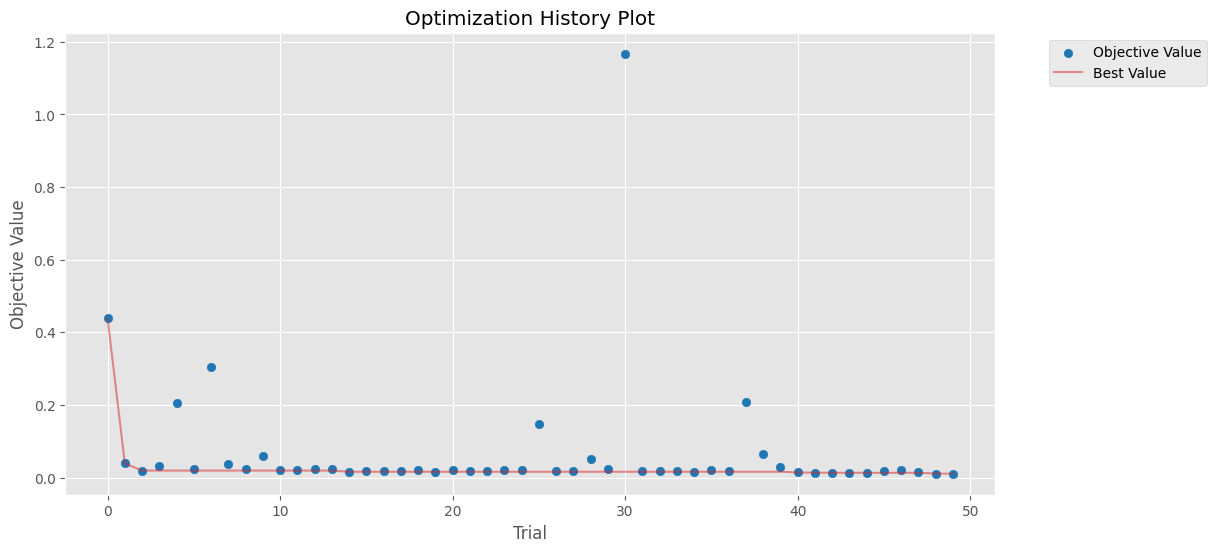

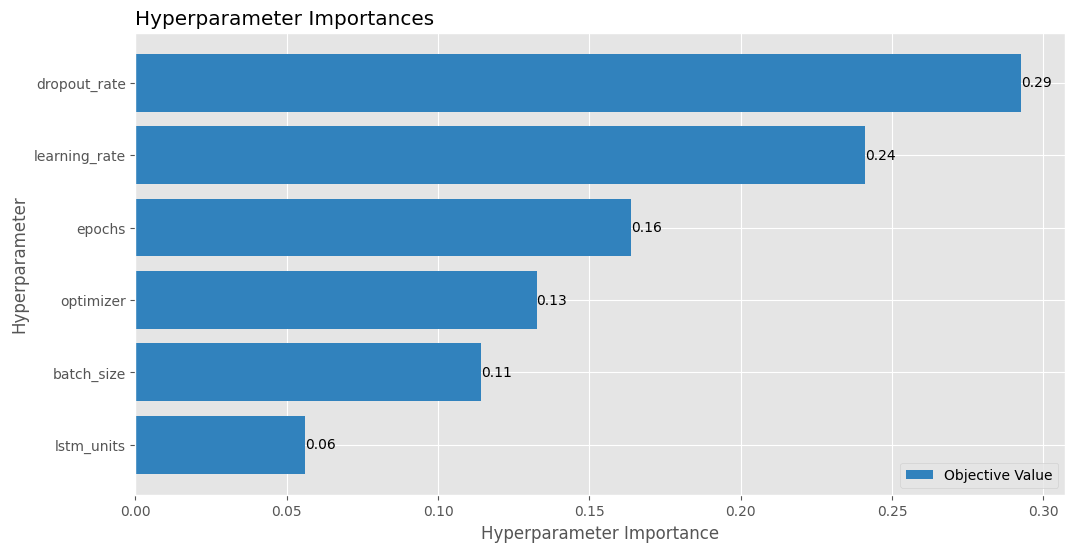

In [15]:
# Plot optimization history and parameter importances
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

In [16]:
# Train final model with best parameters
best_params = study.best_params
model = Sequential([
    LSTM(units=best_params['lstm_units'], input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate']),
    Dense(1)
])

# Select optimizer based on best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

model.compile(optimizer=optimizer, loss='mse')

# Train the model on the full training dataset
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 0.1796 - val_loss: 0.0103
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0701 - val_loss: 0.0065
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0215 - val_loss: 0.0230
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0182 - val_loss: 0.0018
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0235 - val_loss: 0.0076
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0144 - val_loss: 0.0232
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0147 - val_loss: 0.0040
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0120 - val_loss: 0.0027
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0104 - val_loss: 0.0078
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0127 - val_loss: 0.0047
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0096 - val_loss: 0.0023
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0111 - val_loss: 0.0048


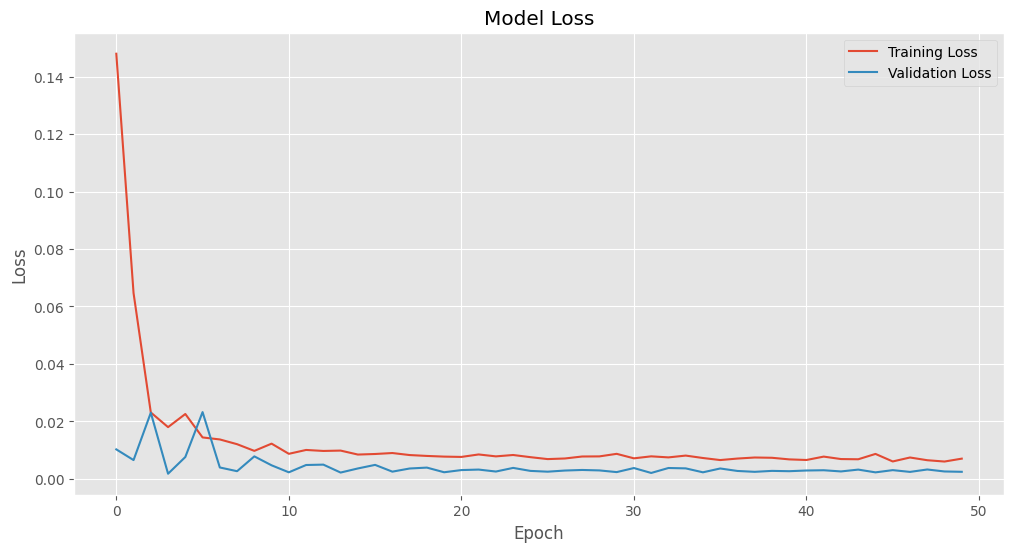

Average Loss: 0.0130


In [17]:
# Fungsi untuk plot training dan validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

average_loss = np.mean(history.history['loss'])
print(f"Average Loss: {average_loss:.4f}")

In [18]:
# Make predictions on the training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [19]:
# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
# Define a function to calculate MAE, MAPE, and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.3f}%'.format(mape))
    print('')

In [21]:
# Evaluasi Model for Training Data
evaluate_prediction(train_predictions, y_train_actual, 'evaluasi model data train')

# Evaluasi Model for Testing Data
evaluate_prediction(test_predictions, y_test_actual, 'evaluasi model data test')

evaluasi model data train:
Mean Absolute Error: 183.277
Root Mean Square Error: 256.629
Mean Absolute Percentage Error: 9.692%

evaluasi model data test:
Mean Absolute Error: 167.137
Root Mean Square Error: 207.104
Mean Absolute Percentage Error: 15.458%



In [22]:
date_train = df['Tanggal'][time_steps:len(y_train_actual) + time_steps]
date_test = df['Tanggal'][-len(y_test_actual):]

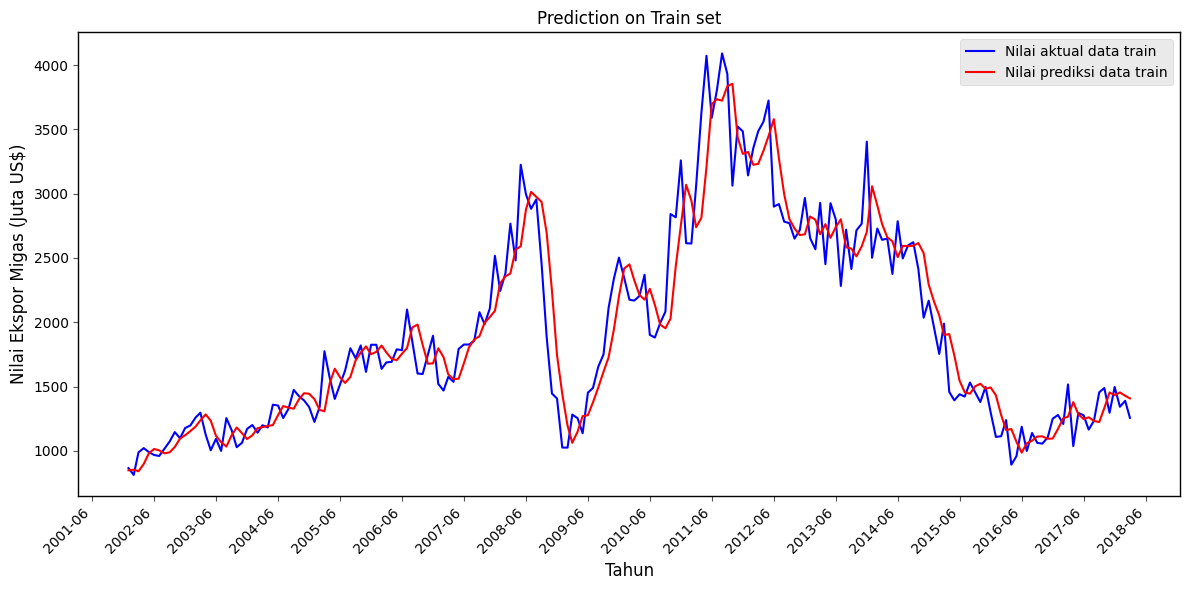

In [23]:
import matplotlib.dates as mdates
# Visualisasi prediksi vs aktual on train data
plt.figure(figsize=(12,6))
plt.title('Prediction on Train set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_train, y_train_actual, label='Nilai aktual data train', color='blue')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train', color='red')
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

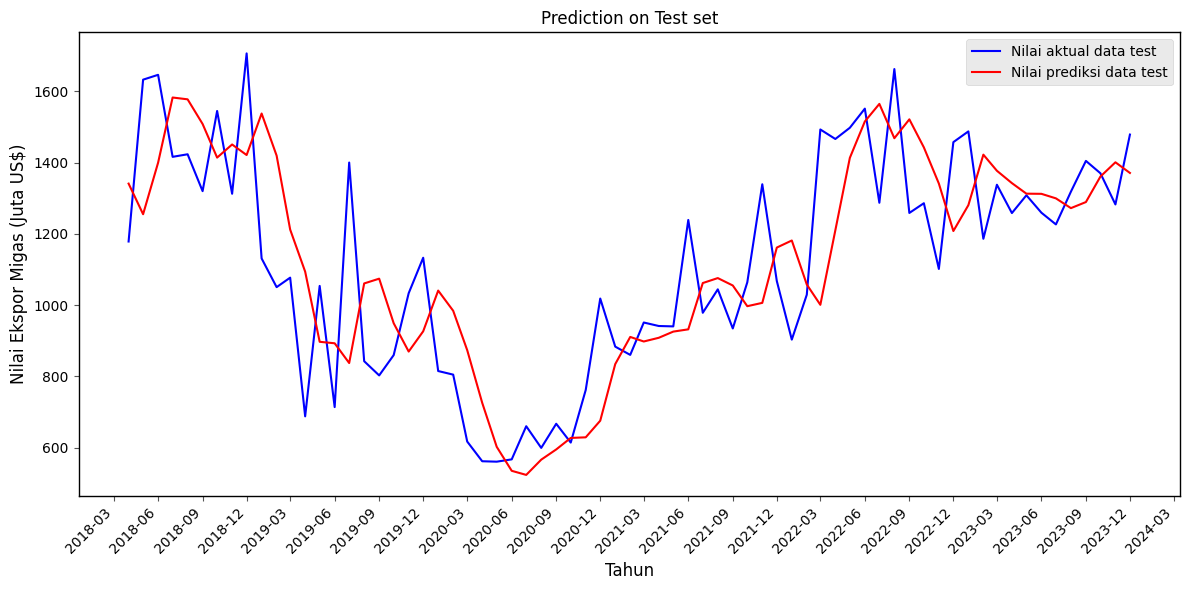

In [24]:
# Visualisasi prediksi vs aktual on test data
plt.figure(figsize=(12,6))
plt.title('Prediction on Test set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test', color='blue')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test', color='red')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better visibility
plt.xticks(rotation=45)  # Memutar label x-axis agar lebih mudah dibaca
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

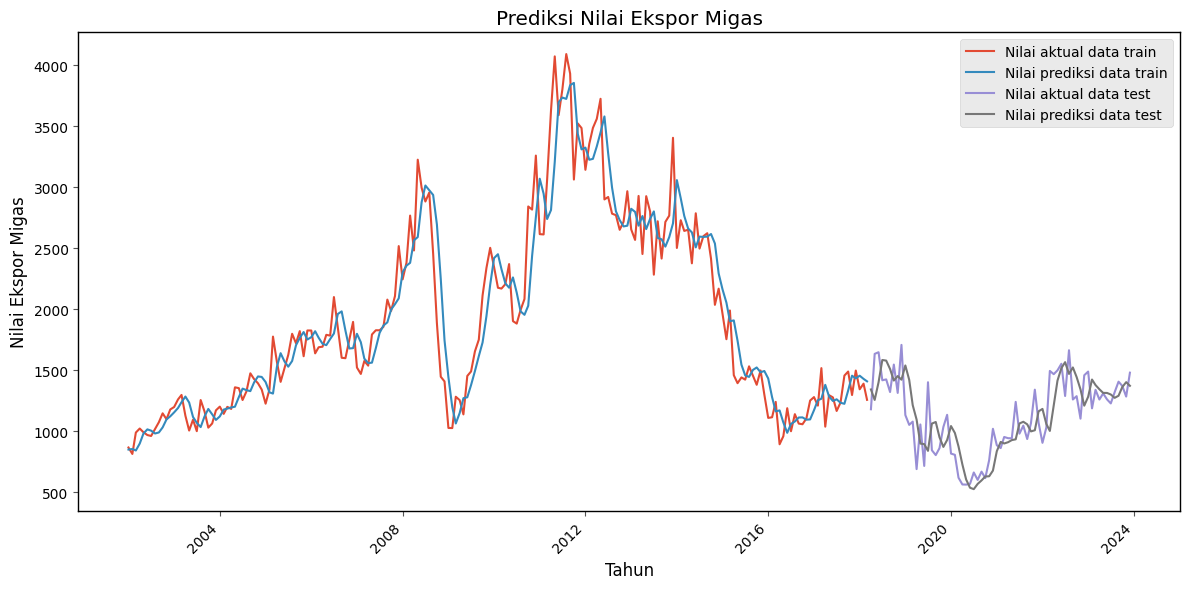

In [25]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(date_train, y_train_actual, label='Nilai aktual data train')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test')
plt.title('Prediksi Nilai Ekspor Migas')
plt.xlabel('Tahun', color='black')
plt.ylabel('Nilai Ekspor Migas', color='black')
plt.legend(fontsize=10)
plt.legend()
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
      Tanggal  Nilai Ekspor Migas (Peramalan)
0  2024-01-01                     1413.509644
1  2024-02-01                     1443.320190
2  2024-03-01                     1461.327881
3  2024-04-01                     1474.990479
4  2024-05-01                     1489.762573
5  2024-06-01                     1504.365356
6  2024-07-01                     1519.511475
7  2024-08-01                     1535.278442
8  2024-09-01                     1550.985352
9  2024-10-01                     1566.710449
10 2024-11-01                     158

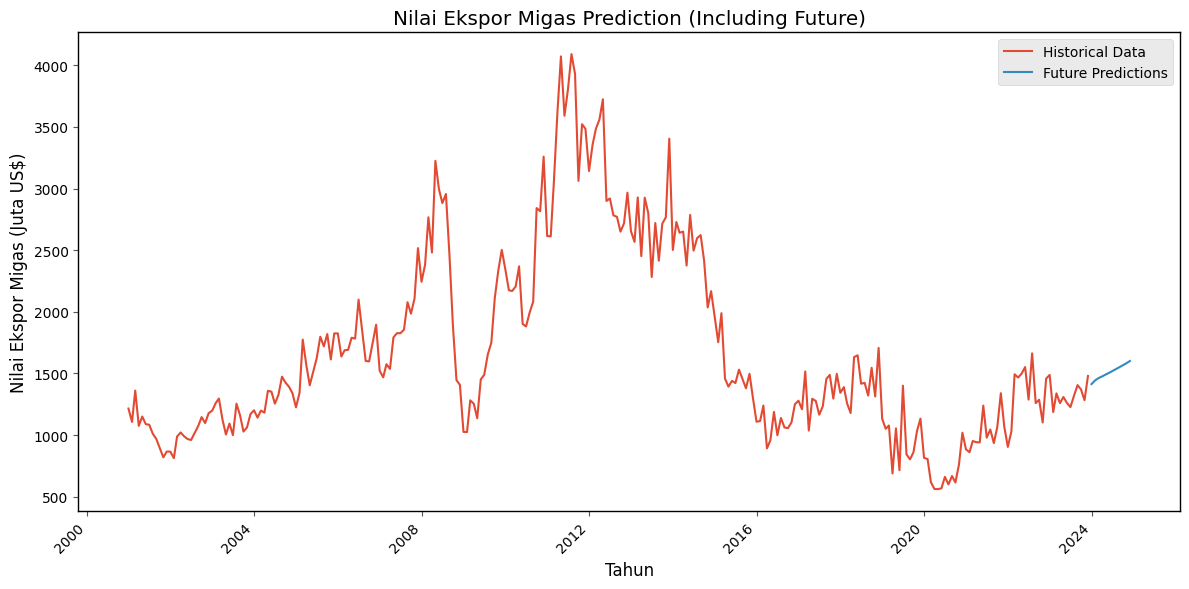

In [26]:
scaled_dt = scaler.fit_transform(dataset)

# Fungsi untuk melakukan peramalan
def forecast_future(model, last_data, periods, scaler):
    future_predictions = []
    current_batch = last_data

    for _ in range(periods):
        # Prediksi satu langkah ke depan
        current_pred = model.predict(current_batch)
        future_predictions.append(current_pred[0])

        # Update batch untuk prediksi berikutnya
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = current_pred[0]

    # Inverse transform hasil peramalan
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Ambil data terakhir untuk input peramalan
last_known_data = scaled_dt[-time_steps:]
last_known_data = last_known_data.reshape((1, time_steps, 1))

# Lakukan peramalan untuk 12 periode ke depan
future_periods = 12
future_predictions = forecast_future(model, last_known_data, future_periods, scaler)

# Buat tanggal untuk hasil peramalan
last_date = df['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=future_periods, freq='MS')

# Buat DataFrame untuk hasil peramalan
forecast_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Nilai Ekspor Migas (Peramalan)': future_predictions.flatten()
})

print(forecast_df)

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(df['Tanggal'], df['Nilai Ekspor Migas'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Nilai Ekspor Migas Prediction (Including Future)')
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()

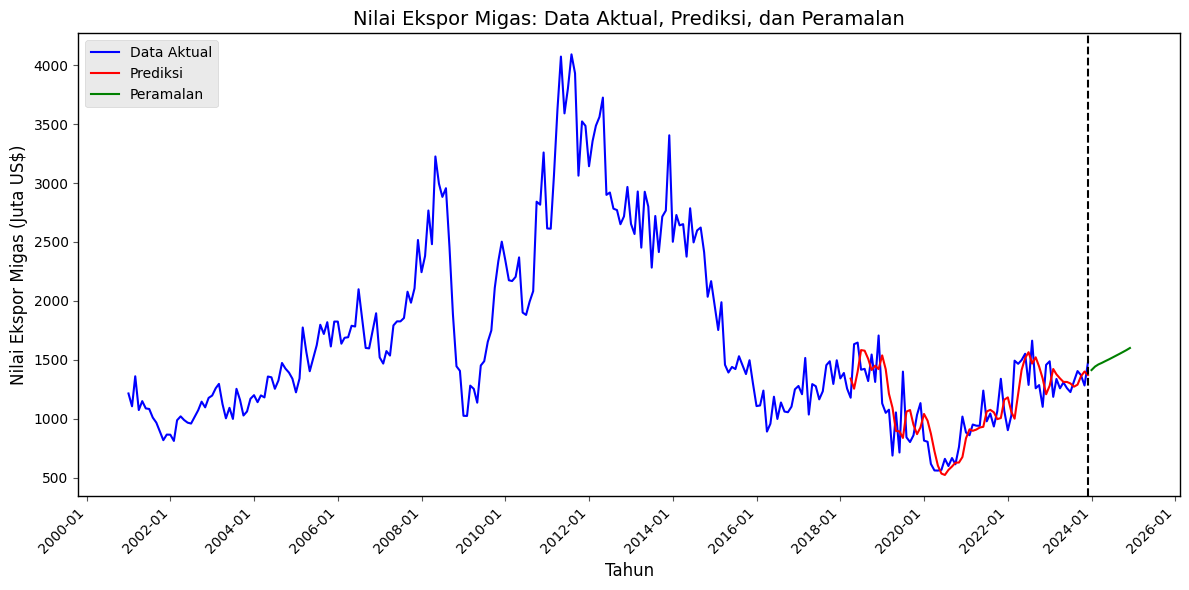

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Mengubah future_dates menjadi Series
future_dates_series = pd.Series(future_dates)

# Menggabungkan data aktual, prediksi data uji, dan hasil peramalan
all_dates = pd.concat([df['Tanggal'], future_dates_series])
all_actual = pd.concat([df['Nilai Ekspor Migas'], pd.Series([np.nan] * len(future_dates))])
all_predictions = np.concatenate([np.array([np.nan] * (len(df) - len(test_predictions))),
                                  test_predictions.flatten(),
                                  future_predictions.flatten()])

# Membuat plot
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_actual, label='Data Aktual', color='blue')

# Garis prediksi
plt.plot(all_dates[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         all_predictions[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         label='Prediksi', color='red')

# Garis peramalan
plt.plot(all_dates[-len(future_predictions):],
         all_predictions[-len(future_predictions):],
         label='Peramalan', color='green')

# Menambahkan garis vertikal untuk memisahkan data uji dan peramalan
split_date = df['Tanggal'].iloc[-1]
plt.axvline(x=split_date, color='black', linestyle='--')

plt.title('Nilai Ekspor Migas: Data Aktual, Prediksi, dan Peramalan', fontsize=14)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')

# Mengatur format tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))

plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [28]:
!pip install openpyxl

In [29]:
forecast_df.to_excel('forecast_75:25_h1t12.xlsx', index=False)
from google.colab import files
files.download('forecast_75:25_h1t12.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import numpy as np
import pandas as pd

# Konversi y_train_actual, train_predictions, y_test_actual, dan test_predictions ke array satu dimensi
y_train_actual = np.array(y_train_actual).flatten()
train_predictions = np.array(train_predictions).flatten()
y_test_actual = np.array(y_test_actual).flatten()
test_predictions = np.array(test_predictions).flatten()

# Buat DataFrame untuk nilai aktual dan prediksi data train
# Membuat DataFrame hasil untuk training dan testing
train_df = pd.DataFrame({
    'Tanggal': date_train.reset_index(drop=True),
    'Data Aktual': y_train_actual,
    'Data Prediksi': train_predictions
})

# Buat DataFrame untuk nilai aktual dan prediksi data test
test_df = pd.DataFrame({
    'Tanggal': date_test.reset_index(drop=True),
    'Data Aktual': y_test_actual,
    'Data Prediksi': test_predictions
})

# Gabungkan train_df dan test_df menjadi satu DataFrame
prediksi_df = pd.concat([train_df, test_df])

# Simpan DataFrame ke dalam file Excel
prediksi_df.to_excel('prediksi_75:25_h1t12.xlsx', index=False)

# Jika Anda menggunakan Google Colab, Anda dapat mengunduh file Excel
from google.colab import files
files.download('prediksi_75:25_h1t12.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>